
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# ミニバッチ確率的勾配降下法

:label: `sec_minibatch_sgd`

これまでのところ、勾配ベースの学習へのアプローチでは 2 つの極端な状況に遭遇しました。 :numref: `sec_gd` 、完全なデータセットを使用して勾配を計算し、一度に 1 パスずつパラメータを更新します。逆に、:numref: `sec_sgd` 、一度に 1 つのトレーニング サンプルを処理して進行します。どちらにも独自の欠点があります。データが非常に類似している場合、勾配降下法は特に*データ効率が*良いわけではありません。 CPU と GPU はベクトル化の能力を最大限に活用できないため、確率的勾配降下法は*計算効率が*あまり高くありません。これは、間に何かがある可能性があることを示唆しており、実際、これまで説明した例ではそれが使用されてきました。

## ベクトル化とキャッシュ

ミニバッチを使用する決定の中心となるのは、計算効率です。これは、複数の GPU と複数のサーバーへの並列化を考えると最も簡単に理解できます。この場合、少なくとも 1 つの画像を各 GPU に送信する必要があります。サーバーあたり 8 GPU と 16 サーバーを使用すると、ミニバッチ サイズはすでに 128 以上に達します。

単一の GPU や CPU に関しては、状況はもう少し微妙です。これらのデバイスには複数の種類のメモリがあり、多くの場合、複数の種類の計算ユニットがあり、それらの間で異なる帯域幅制約があります。たとえば、CPU には少数のレジスタがあり、さらに L1、L2、場合によっては L3 キャッシュ (異なるプロセッサ コア間で共有される) もあります。これらのキャッシュのサイズと遅延は増加しています (同時に帯域幅も減少しています)。プロセッサは、メイン メモリ インターフェイスが提供できる操作よりもはるかに多くの操作を実行できると言えば十分でしょう。

まず、16 コアと AVX-512 ベクトル化を備えた 2 GHz CPU は、1 秒あたり最大 $2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$ バイトを処理できます。 GPU の能力は、この数値をゆうに 100 倍超えます。一方、ミッドレンジ サーバー プロセッサの帯域幅は 100 GB/s をはるかに超えない可能性があります。つまり、プロセッサの維持に必要な帯域幅の 10 分の 1 未満です。餌を与えた。さらに悪いことに、すべてのメモリ アクセスが均等に作成されるわけではありません。メモリ インターフェイスは通常 64 ビット幅以上 (たとえば、GPU では最大 384 ビット) であるため、単一バイトの読み取りには、より広いアクセスのコストがかかります。

第 2 に、最初のアクセスではかなりのオーバーヘッドが発生しますが、シーケンシャル アクセスは比較的安価です (これはバースト読み取りと呼ばれることがよくあります)。複数のソケット、チップレット、その他の構造がある場合のキャッシュなど、留意すべき点は他にもたくさんあります。さらに詳しい議論については、この[Wikipedia の記事](https://en.wikipedia.org/wiki/Cache_hierarchy)を参照してください。

これらの制約を軽減する方法は、プロセッサにデータを供給するのに実際に十分な速度を持つ CPU キャッシュの階層を使用することです。これがディープラーニングにおけるバッチ処理の*原動力*です。話を単純にするために、$\mathbf{A} = \mathbf{B}\mathbf{C}$ のように、行列と行列の乗算を考えてみましょう。 $\mathbf{A}$ を計算するためのオプションが多数あります。たとえば、次のことを試すことができます。
1.  $\mathbf{A} *{ij} = \mathbf{B}* {i,:} \mathbf{C}_{:,j}$ を計算できます。つまり、ドット積を使用して要素ごとに計算できます。
1.  $\mathbf{A} *{:,j} = \mathbf{B} \mathbf{C}* {:,j}$ を計算できます。つまり、一度に 1 列ずつ計算できます。同様に、$\mathbf{A}$ を一度に 1 行 $\mathbf{A}_{i,:}$ 計算することができます。
1.  $\mathbf{A} = \mathbf{B} \mathbf{C}$ を単純に計算できます。
1.  $\mathbf{B}$ と $\mathbf{C}$ をより小さなブロック行列に分割し、$\mathbf{A}$ を一度に 1 ブロックずつ計算できます。

最初のオプションに従う場合、要素 $\mathbf{A} *{ij}$ を計算するたびに、1 つの行ベクトルと 1 つの列ベクトルを CPU にコピーする必要があります。さらに悪いことに、行列要素は順番に整列されるため、メモリから読み取るときに 2 つのベクトルのうちの 1 つについて多くの互いに素な位置にアクセスする必要があります。 2 番目のオプションの方がはるかに有利です。その中で、$\mathbf{B}$ を走査し続ける間、列ベクトル $\mathbf{C} {:,j}$ を CPU キャッシュに保持することができます*。これにより、メモリ帯域幅の要件が半分になり、それに応じてアクセスが高速化されます。もちろん、オプション 3 が最も望ましいです。残念ながら、ほとんどの行列はキャッシュに完全に収まらない可能性があります (結局のところ、これが私たちが議論していることです)。ただし、オプション 4 は、実際に役立つ代替手段を提供します。つまり、行列のブロックをキャッシュに移動し、それらをローカルで乗算することができます。最適化されたライブラリがこれを処理します。これらの操作が実際にどの程度効率的であるかを見てみましょう。

計算効率を超えて、Python と深層学習フレームワーク自体によってもたらされるオーバーヘッドはかなりのものです。コマンドを実行するたびに、Python インタプリタが MXNet エンジンにコマンドを送信し、MXNet エンジンはそのコマンドを計算グラフに挿入し、スケジューリング中に処理する必要があることを思い出してください。このようなオーバーヘッドは非常に有害となる可能性があります。つまり、可能な限りベクトル化 (および行列) を使用することを強くお勧めします。


In [1]:
%matplotlib inline
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)


この本の残りの部分では実行時間のベンチマークを頻繁に行うため、タイマーを定義しましょう。


In [2]:
class Timer:  #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

timer = Timer()


要素ごとの割り当ては、$\mathbf{B}$ と $\mathbf{C}$ のすべての行と列をそれぞれ単純に反復して、値を $\mathbf{A}$ に割り当てます。


In [3]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.5775339603424072


より高速な戦略は、列単位の割り当てを実行することです。


In [4]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

1.0594699382781982


最後に、最も効果的な方法は、操作全体を 1 つのブロックで実行することです。任意の 2 つの行列 $\mathbf{B} \in \mathbb{R}^{m \times n}$ と $\mathbf{C} \in \mathbb{R}^{n \times p}$ を乗算するには、スカラー乗算と加算が別個の演算としてカウントされる場合 (実際には融合されています)、約 $2mnp$ の浮動小数点演算。したがって、2 つの $256 \times 256$ 行列を乗算するには、0.03$ 億ドルの浮動小数点演算が必要になります。それぞれの操作の速度を見てみましょう。


In [5]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

gigaflops = [0.03 / i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.019, column 0.028, full 2.167



## ミニバッチ

:label: `sec_minibatches`

以前は、パラメーターを更新するために単一の観測値ではなく、データの*ミニバッチを*読み取ることが当然だと考えられていました。ここで、その理由を簡単に説明します。単一の観測を処理するには、単一の行列とベクトル (またはベクトルとベクトル) の乗算を多数実行する必要がありますが、これは非常にコストがかかり、基礎となる深層学習フレームワークに多大なオーバーヘッドが発生します。これは、データに適用されるネットワークの評価 (推論と呼ばれることが多い) と、パラメーターを更新するための勾配を計算するときの両方に当てはまります。つまり、これは $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ を実行するたびに適用されます。

 $$\mathbf{g} *t = \partial* {\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$$

この操作を一度に観測値のミニバッチに適用することで、*計算*効率を高めることができます。つまり、単一の観測値の勾配 $\mathbf{g}_t$ を小さなバッチの 1 に置き換えます。

 $$\mathbf{g} *t = \partial* {\mathbf{w}} \frac{1}{|\mathcal{B} *t|} \sum* {i \in \mathcal{B} *t} f(\mathbf {x}* {i}, \mathbf{w})$$

これが $\mathbf{g}_t$ の統計的性質にどう影響するかを見てみましょう: $\mathbf{x}_t$ とミニバッチ $\mathcal{B}_t$ のすべての要素の両方が、以下から一様にランダムに抽出されるためです。トレーニング セットでは、勾配の期待値は変更されません。一方、分散は大幅に減少します。ミニバッチ勾配は平均化される $b \stackrel{\mathrm{def}}{=} |\mathcal{B}_t|$ の独立した勾配で構成されているため、その標準偏差は $b^{ の係数で減少します。 -\frac{1}{2}}$。これは、更新がより確実に完全なグラデーションと一致することを意味するため、それ自体は良いことです。

素朴にこれは、大きなミニバッチ $\mathcal{B}_t$ を選択することが普遍的に望ましいことを示しています。悲しいことに、ある時点を過ぎると、計算コストの直線的な増加と比較すると、標準偏差の追加の減少は最小限になります。実際には、GPU のメモリに収まりながら、優れた計算効率を提供できる十分な大きさのミニバッチを選択します。節約を説明するために、いくつかのコードを見てみましょう。そこでは同じ行列と行列の乗算を実行しますが、今回は一度に 64 列の「ミニバッチ」に分割されます。


In [6]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {0.03 / timer.times[3]:.3f}')

performance in Gigaflops: block 0.655



ご覧のとおり、ミニバッチでの計算は基本的に完全な行列での計算と同じくらい効率的です。注意が必要です。 :numref: `sec_batch_norm`では、ミニバッチ内の分散量に大きく依存するタイプの正則化を使用しました。後者を増やすと、分散が減少し、それに伴ってバッチ正規化によるノイズ挿入の利点が得られます。適切な項を再スケーリングして計算する方法の詳細については、:citet: `Ioffe.2017`を参照してください。

## データセットの読み取り

ミニバッチがデータからどのように効率的に生成されるかを見てみましょう。以下では、NASA によって開発されたデータセットを使用して、[さまざまな航空機の翼騒音](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)をテストし、これらの最適化アルゴリズムを比較します。便宜上、最初の $1,500$ の例のみを使用します。データは前処理のために白色化されます。つまり、平均を削除し、分散を座標ごとに $1$ に再スケールします。


In [7]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1


## ゼロからの実装

:numref: `sec_linear_scratch`のミニバッチ確率的勾配降下法の実装を思い出してください。以下では、もう少し一般的な実装を示します。便宜上、この章で後ほど紹介する他の最適化アルゴリズムと同じ呼び出しシグネチャを持ちます。具体的には、ステータス入力`states`を追加し、ハイパーパラメータをディクショナリ`hyperparams`に配置します。さらに、トレーニング関数の各ミニバッチ サンプルの損失を平均するため、最適化アルゴリズムの勾配をバッチ サイズで割る必要はありません。


In [8]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()


次に、この章で後ほど紹介する他の最適化アルゴリズムの使用を容易にするための汎用トレーニング関数を実装します。これは線形回帰モデルを初期化し、ミニバッチ確率的勾配降下法やその後導入される他のアルゴリズムを使用してモデルをトレーニングするために使用できます。


In [9]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]


バッチ勾配降下法の最適化がどのように進行するかを見てみましょう。これは、ミニバッチ サイズを 1500 (つまり、サンプルの総数) に設定することで実現できます。結果として、モデル パラメーターはエポックごとに 1 回だけ更新されます。進歩はほとんどありません。実際、6 ステップ後には進歩が停滞します。


loss: 0.249, 0.036 sec/epoch


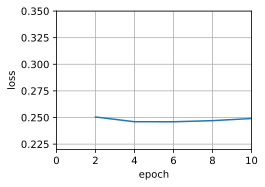

In [10]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)


バッチ サイズが 1 の場合、最適化には確率的勾配降下法が使用されます。実装を簡素化するために、(小さいとはいえ) 一定の学習率を選択しました。確率的勾配降下法では、例が処理されるたびにモデル パラメーターが更新されます。この場合、これはエポックごとに 1500 回の更新に相当します。見てわかるように、目的関数の値の減少は 1 エポック後に減速します。どちらの手順も 1 エポック内で 1500 個の例を処理しましたが、実験では確率的勾配降下法は勾配降下法よりも多くの時間を費やします。これは、確率的勾配降下法ではパラメーターがより頻繁に更新され、一度に 1 つの観測値を 1 つずつ処理するのは効率が低いためです。


loss: 0.242, 0.767 sec/epoch


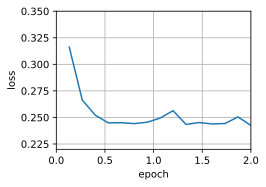

In [11]:
sgd_res = train_sgd(0.005, 1)


最後に、バッチ サイズが 100 に等しい場合、最適化のためにミニバッチ確率的勾配降下法を使用します。エポックごとに必要な時間は、確率的勾配降下法に必要な時間やバッチ勾配降下法に必要な時間よりも短くなります。


loss: 0.242, 0.028 sec/epoch


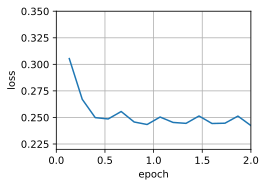

In [12]:
mini1_res = train_sgd(.4, 100)


バッチ サイズを 10 に減らすと、各バッチのワークロードの実行効率が低下するため、各エポックの時間が増加します。


loss: 0.247, 0.107 sec/epoch


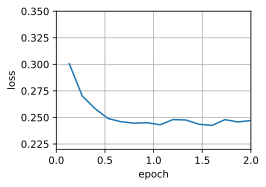

In [13]:
mini2_res = train_sgd(.05, 10)


ここで、前の 4 つの実験の時間と損失を比較できます。ご覧のとおり、確率的勾配降下法は、処理されるサンプル数の点では GD よりも早く収束しますが、サンプルごとに勾配を計算するのがそれほど効率的ではないため、同じ損失に達するまでに GD よりも多くの時間がかかります。ミニバッチの確率的勾配降下法では、収束速度と計算効率をトレードオフできます。ミニバッチ サイズ 10 は、確率的勾配降下法よりも効率的です。ミニバッチ サイズが 100 の場合でも、実行時間の点では GD を上回ります。


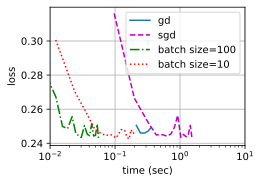

In [14]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')


## 簡潔な実装

Gluon では、 `Trainer`クラスを使用して最適化アルゴリズムを呼び出すことができます。これは、一般的なトレーニング関数を実装するために使用されます。これをこの章全体で使用します。


In [15]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(module):
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')


Gluon を使用して最後の実験を繰り返すと、同じ動作が示されます。


loss: 0.242, 0.111 sec/epoch


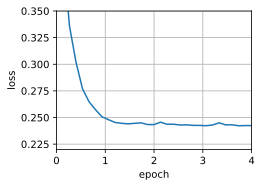

In [16]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)


## まとめ
- ベクトル化により、深層学習フレームワークによるオーバーヘッドの削減と、CPU および GPU でのメモリの局所性とキャッシュの向上により、コードの効率が向上します。
- 確率的勾配降下法から生じる統計的効率と、一度に大量のデータを処理することから生じる計算効率との間にはトレードオフの関係があります。
- ミニバッチの確率的勾配降下法は、計算効率と統計効率の両方の長所を提供します。
- ミニバッチ確率的勾配降下法では、トレーニング データのランダムな並べ替えによって取得されたデータのバッチを処理します (つまり、各観測値は、ランダムな順序であっても、エポックごとに 1 回だけ処理されます)。
- トレーニング中は学習率を下げることをお勧めします。
- 一般に、クロック時間の観点から測定した場合、ミニバッチの確率的勾配降下法は、確率的勾配降下法や勾配降下法よりも小さいリスクへの収束が高速です。

## 演習
1. バッチ サイズと学習率を変更し、目的関数の値の減少率と各エポックで消費される時間を観察します。
1.  MXNet ドキュメントを読み、 `Trainer`クラスの`set_learning_rate`関数を使用して、ミニバッチの確率的勾配降下法の学習率を各エポック後の前の値の 1/10 に下げます。
1. ミニバッチの確率的勾配降下法を、トレーニング セットからの*置換で実際にサンプリングする*バリアントと比較します。何が起こるのですか？
1. 邪悪な魔神は、あなたに何も言わずにデータセットを複製します (つまり、各観測が 2 回発生し、データセットが元のサイズの 2 倍に成長しますが、誰もあなたに教えませんでした)。確率的勾配降下法、ミニバッチ確率的勾配降下法、および勾配降下法の挙動はどのように変化しますか?



[ディスカッション](https://discuss.d2l.ai/t/1068)
